In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import seaborn as sns

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import datasets

In [90]:
all_images = []

folder_path = "labels"

for file in os.listdir(folder_path):
    if file.lower().endswith(".tiff"):
        ndvi_path = os.path.join(folder_path, file)
        with rasterio.open(ndvi_path) as src:
            ndvi_data = src.read(1)

            # Handle NoData if exists
            if src.nodata is not None:
                ndvi_data = np.where(ndvi_data == src.nodata, np.nan, ndvi_data)

            # Flatten 256x256 → 1D (65536 values)
            flat_pixels = ndvi_data.flatten()

            # Add this image's pixel values as one row
            all_images.append(flat_pixels)

all_images_array = np.array(all_images)

print(f"✅ Final 2D array shape: {all_images_array.shape}")
print(f"➡️ Rows = images, Columns = pixels")
print(f"📊 Value range: {np.nanmin(all_images_array):.4f} to {np.nanmax(all_images_array):.4f}")
print(f"📈 Mean value: {np.nanmean(all_images_array):.4f}")

c:\Users\MSPun\Documents\Code\Research\Task 22\Learning_Path\.venv\Lib\site-packages\rasterio\__init__.py:368: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


✅ Final 2D array shape: (614, 65536)
➡️ Rows = images, Columns = pixels
📊 Value range: 37.0000 to 229.0000
📈 Mean value: 174.9086


In [91]:
# Use the all_images_array from the previous cell
# Each row is one sample (image), each column is a pixel value (feature)
X = all_images_array

# Use the labels created based on NDVI values (y_labels)
# 0 = Unhealthy (darker/low NDVI), 1 = Healthy (lighter/high NDVI)
y = y_labels

print(f"X shape: {X.shape}")  # Should be (n_samples, n_features)
print(f"y shape: {y.shape}")  # Should be (n_samples,)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features (important for SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the SVM classifier
clf = svm.SVC(kernel='linear', C=1.0)
clf.fit(X_train_scaled, y_train)

# Evaluate the model
train_score = clf.score(X_train_scaled, y_train)
test_score = clf.score(X_test_scaled, y_test)

print(f"\nTraining accuracy: {train_score:.4f}")
print(f"Test accuracy: {test_score:.4f}")
print(f"Number of support vectors: {len(clf.support_vectors_)}")

X shape: (614, 65536)
y shape: (614,)

Training accuracy: 1.0000
Test accuracy: 0.9512
Number of support vectors: 99

Training accuracy: 1.0000
Test accuracy: 0.9512
Number of support vectors: 99


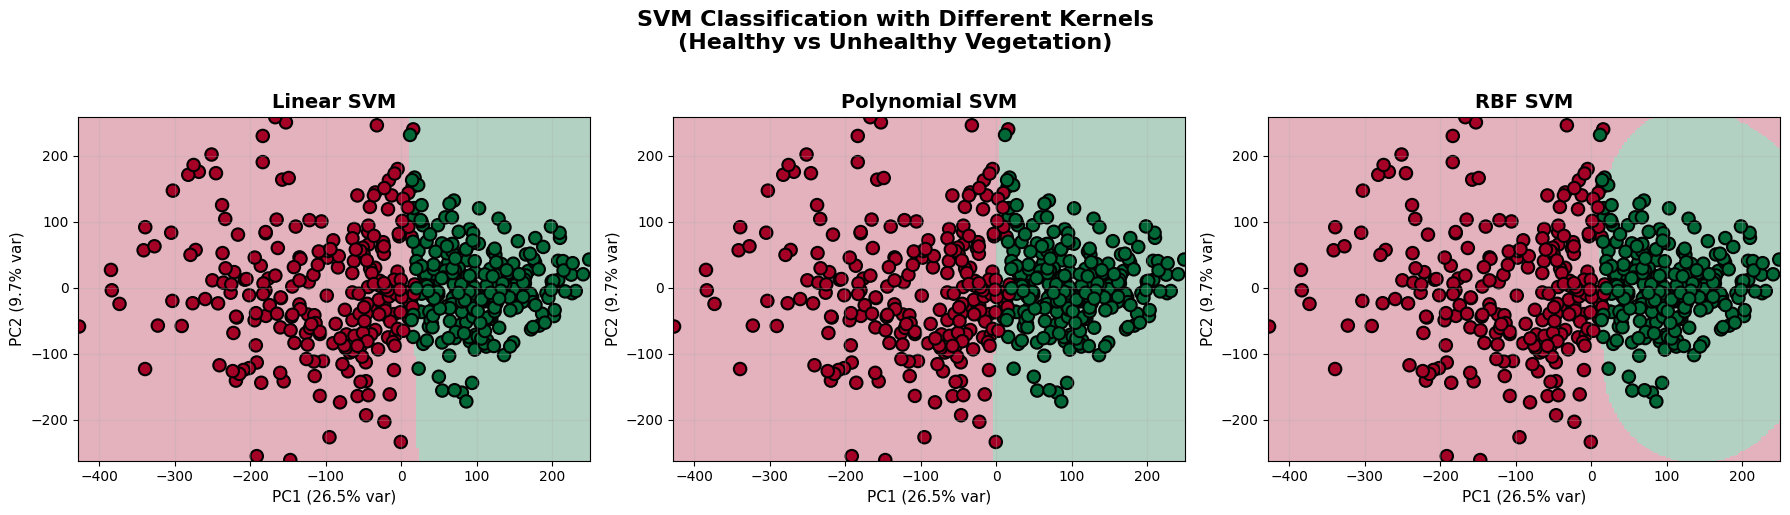


Model Performance Comparison (on 2D PCA data):
Linear SVM          : Accuracy = 0.9919
Polynomial SVM      : Accuracy = 0.9350
RBF SVM             : Accuracy = 1.0000


In [92]:
# Linear visualizer using matplotlib scatter with different SVM kernels
from sklearn.decomposition import PCA

# Reduce to 2D using PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)
y_pca = y_train

# Create different SVM models with different kernels
models = [
    svm.SVC(kernel='linear', C=1.0),
    svm.SVC(kernel='poly', degree=3, C=1.0),
    svm.SVC(kernel='rbf', C=1.0)
]

model_names = ['Linear SVM', 'Polynomial SVM', 'RBF SVM']

# Create mesh for decision boundary
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

def fit_and_create_boundary(model):
    model.fit(X_pca, y_pca)
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    return Z

# Create visualization
plt.figure(figsize=(18, 5))

for i, model in enumerate(models):
    plt.subplot(1, 3, i + 1)
    
    # Fit model and get decision boundary
    Z = fit_and_create_boundary(model)
    
    # Plot decision boundary with pcolormesh
    plt.pcolormesh(xx, yy, Z, cmap=plt.cm.RdYlGn, alpha=0.3, shading='auto')
    
    # Plot training points
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], 
                         c=y_pca, edgecolors='k', 
                         cmap=plt.cm.RdYlGn, s=80, linewidths=1.5)
    
    plt.title(model_names[i], fontsize=14, fontweight='bold')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} var)', fontsize=11)
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} var)', fontsize=11)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.grid(True, alpha=0.3)

plt.suptitle('SVM Classification with Different Kernels\n(Healthy vs Unhealthy Vegetation)', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Print accuracy for each model
print("\n" + "="*60)
print("Model Performance Comparison (on 2D PCA data):")
print("="*60)
for i, model in enumerate(models):
    # Get test data in PCA space
    X_test_pca = pca.transform(X_test_scaled)
    accuracy = model.score(X_test_pca, y_test)
    print(f"{model_names[i]:20s}: Accuracy = {accuracy:.4f}")
print("="*60)